In [11]:
import pandas as pd
import numpy as np
import regex as reg
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import pickle
import re
import os
%matplotlib inline

There are 2 kind of data available for this analysis:
    - The structured data: a dictionary containing numerous features
    - The unstructured: a lots of emails.
    
I will attempt to use both of them to identify person of interest. First with the structured, then the unstructured.

# STRUCTURED DATA SET

#### 1. THE DATA SET

In [12]:
from feature_format import featureFormat, targetFeatureSplit

data_dict = pickle.load(open("final_project_dataset.pkl", "r") )

features_list = ["bonus", 'deferral_payments', 'deferred_income', 
                 'director_fees', 'exercised_stock_options', 
                 "expenses", 'from_messages', 'loan_advances',
                 'long_term_incentive', 'other', 'restricted_stock', 
                 'restricted_stock_deferred', 'salary', 'to_messages', 
                 'total_payments', 'total_stock_value']

data = featureFormat(data_dict, features_list)

In [13]:
print 'Total number of data points: {}'.format(len(data_dict))
POI = 0
for person in data_dict:
    if data_dict[person]['poi'] == True:
        POI += 1
non_POI = len(data_dict) - POI

print ('Alocation across class (POI/non-POI): {}'.
       format(POI/float(non_POI)))
print 'Number of features used: {}'.format(len(features_list))


Total number of data points: 146
Alocation across class (POI/non-POI): 0.140625
Number of features used: 16


In [14]:
data_avail = {}
for feature in features_list:
    data = featureFormat(data_dict, [feature])
    data_avail[feature] = len(data) 

data_avail

{'bonus': 82,
 'deferral_payments': 39,
 'deferred_income': 49,
 'director_fees': 17,
 'exercised_stock_options': 102,
 'expenses': 95,
 'from_messages': 86,
 'loan_advances': 4,
 'long_term_incentive': 66,
 'other': 93,
 'restricted_stock': 110,
 'restricted_stock_deferred': 18,
 'salary': 95,
 'to_messages': 86,
 'total_payments': 125,
 'total_stock_value': 126}

The median of allocation across data points (non-missing/ missing) are 0.57.

Therefore, I defined features with many missing values as any features that have less than 0.57 available data points.

In [15]:
features_with_many_nan = 0
total_miss = 0
for feature in data_avail:
    total_miss += data_avail[feature]
    if (data_avail[feature] / float(len(data_dict))) < 0.57:
        features_with_many_nan += 1
values = np.array(list(data_avail.values()))
print ('Median of data points available: {}'
       .format(np.median(values)/len(data_dict)))
print ('Features with many missing values: {}'
       .format(features_with_many_nan))

Median of data points available: 0.58904109589
Features with many missing values: 7


#### 2. THE OUTLIERS:




Before doing anything, it is imperitive to dive into the data, and try to understand it as deeply as you could.

First, I will attempt to visualize all the data points of all the features available. I want to see if there was some kind of special shape, and to inspect on the state of outliers as well as the noise (the noise are the data from people who are not person of interest)

So I'm going to plot the data across the x-axis, seperated by different features. I don't care about the y-axis, because I only want to look at the shape of the data.

  feature  poi      value
0   bonus  0.0   600000.0
1   bonus  0.0  1200000.0
2   bonus  0.0   350000.0
3   bonus  1.0  1500000.0
4   bonus  0.0   325000.0


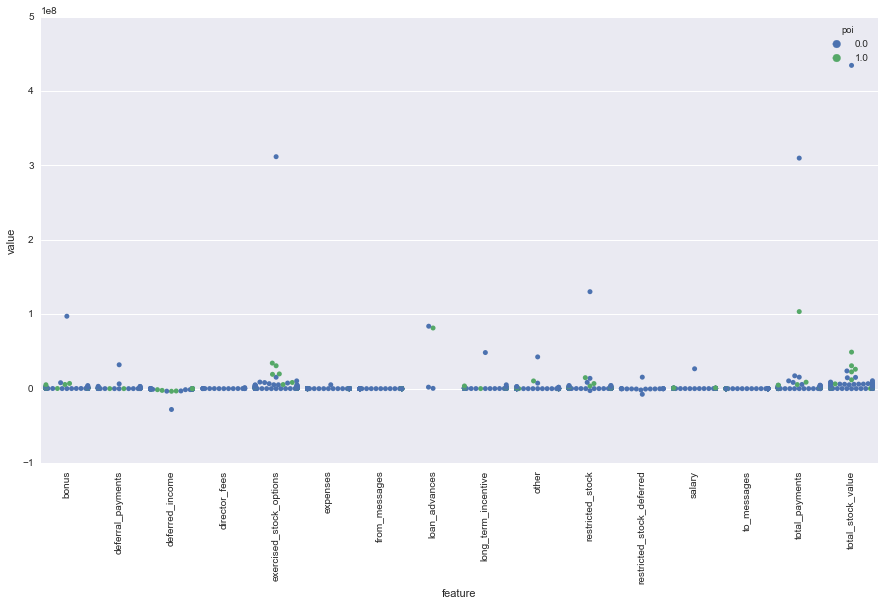

In [16]:
def prepare_plotting_data(input_data, features_list):
    '''
    Given the input_data, which is a dict of dict, extract feature 
    one by one from the list of given features_list.
    Reformat it (remove NaN and 0)
    Return a pandas dataframe of the long format, containing 
    these fields: (feature, poi, value)
    '''
    
    features_data = pd.DataFrame({'value': [], 'poi': [], 'feature': []})
    for feature in features_list:
        feature_data = featureFormat(input_data, ['poi', feature])
        extracted_feature_data = feature_data[:, 1]
        data = pd.DataFrame(feature_data, columns=('poi', 'value'))
        data['feature'] = feature
        features_data = pd.concat([features_data, data])
    return features_data
features_data = prepare_plotting_data(data_dict, features_list)
print features_data.head()

def create_swarmplot(data):
    'Plot a swarmplot from the data created by prepare_plotting_data'
    
    fig = plt.figure(1, figsize=(15, 8))
    ax = fig.add_subplot(111)
    sns.swarmplot(x="feature", y="value", hue="poi", data=data);
    ax.set_xticklabels(features_list, rotation='vertical')
create_swarmplot(features_data)

So there are quite a few outliers in this dataset.

The one in green represent those that we care about, person of interest, while the one in blue represent the noise, I will remove the blue outliers.

One widely used definition of outlier is that any data point more than 1.5 interquartile ranges (IQRs) below the first quartile or above the third quartile.

But it really is depends. In this case, I will just go with the default 1.5 first, and will come back to tune it later, if the situation calls for.

In [17]:
def outliers_identifier(data, distance):
    '''
    Given a numpy array data, identify the outliers according to 
    the input IQRs ranges, return a list containing the index of 
    all the outliers
    '''
    # Calculate the q25, q75 and the IQR
    q75, q25 = np.percentile(data, [75 ,25])
    iqr = q75 - q25
    
    threshold_high = q75 + iqr*distance
    threshold_low = q25 - iqr*distance
    
    # Subset the outliers, which are either lower than threshold_low, 
    # or higher than threshold_high
    outliers = data[(data > threshold_high) + (data < threshold_low)]
    outliers_index = []
    
    for datapoint in outliers:
        if len(np.where(data == datapoint)[0]) == 1:
            outliers_index.append(np.where(data == datapoint)[0][0])
        else:
            for datapoint_in_list in np.where(data == datapoint)[0]:
                outliers_index.append(datapoint_in_list)
    return outliers_index

I removed the outliers, and put all the information in a long pandas dataframe, and created a swarmplot to show the shape of the data.

I added another field 'id' to keep track of the origin of features and values.

removed 103 outliers out of 1193 data points
  feature   id  poi      value
0   bonus  1.0  0.0   600000.0
1   bonus  2.0  0.0  1200000.0
2   bonus  3.0  0.0   350000.0
3   bonus  5.0  1.0  1500000.0
4   bonus  6.0  0.0   325000.0


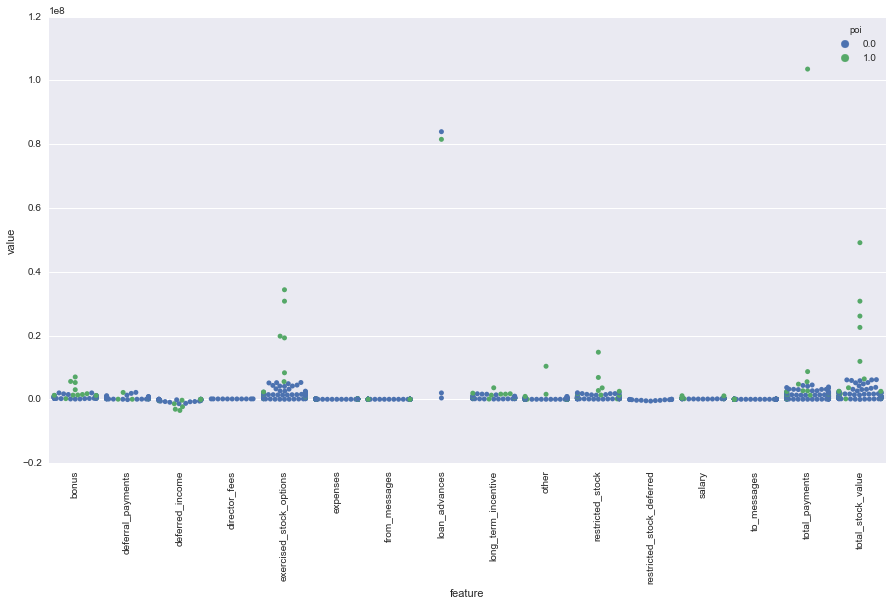

In [18]:
# Add id to the data_dict
id = 1
for key in data_dict:
    data_dict[key]['id'] = id
    id += 1

def remove_outliers(input_data, features_list):
    '''
    Given the input_data, which is a dict of dict, extract feature 
    one by one from the list of given features_list.
    Reformat it (remove NaN and 0)
    Find and remove the outliers
    Return a pandas dataframe of the long format, containing 
    these fields: (id,feature, poi, value)
    
    '''
    cleaned_data = pd.DataFrame({'value': [], 'id': [], 
                                 'poi': [], 'feature': []})
    total_deleted_points = 0
    for feature in features_list:
        # Extract feature information, stored them under long format
        # with corresponding 'poi' and 'id' data, remove 'NaN' and zeroes.
        data = featureFormat(input_data, ['poi', 'id', feature], 
                             remove_any_zeroes=True)
        
        # Take out the feature data
        extracted_feature_data = data[:, 2]
        
        # Use the function outliers_identifier to identify the outliers
        outliers_index = np.apply_along_axis(outliers_identifier, 0, 
                                             extracted_feature_data, 1.5)
        
        # Remove duplicate values
        outliers_index = np.unique(outliers_index)
        
        # Remove the datapoint according to the index stored in 
        # outliers_index. Deleted_points will record the number 
        # of deletions, and serve as adjustment point, since
        # the index will move up with each deletion.
        deleted_points = 0
        for datapoints in outliers_index:
            datapoints = datapoints - deleted_points
            if data[datapoints][0] == 1:
                pass
            else:
                data = np.delete(data, datapoints, 0)
                deleted_points += 1
        total_deleted_points += deleted_points
        
        # Store the data on a pandas dataframe outside of the loop 
        # once done removing the outliers
        data = pd.DataFrame(data, columns=('poi', 'id', 'value'))
        data['feature'] = feature
        cleaned_data = pd.concat([cleaned_data, data])
    print ('removed {} outliers out of {} data points'
           .format(total_deleted_points, 
                   (len(cleaned_data) + total_deleted_points)))
    return cleaned_data
outliers_free_data = remove_outliers(data_dict, features_list)
print outliers_free_data.head()

create_swarmplot(outliers_free_data)

It looks so much better now, most of the noises had been removed.

#### 3. MODELLING

Sklearn doesn't really play well with pandas, so I will first reshape it to wide pandas, then convert it back to numpy.

In [19]:
# Pivot to wide pandas using 'id', 'feature' and 'value'. 'poi' is 
# temporarily left behind, I will go back in pick it up later
outliers_free_data_w = outliers_free_data.pivot(index='id', 
                                                columns='feature', 
                                                values= 'value')

# Reset the index, but keep the id column
outliers_free_data_w = outliers_free_data_w.reset_index(drop=False)

# Pick up the 'poi' data left behind earlier
outliers_free_data_w = pd.merge(outliers_free_data_w, 
                                (outliers_free_data[['id', 'poi']]
                                 .drop_duplicates()), 
                                how='left', on='id')

# Store the name of the features and labels, these information 
# will be used later.
feature_names = (list(outliers_free_data_w.columns.values)
                 [:len(outliers_free_data_w.columns)-1])
label_names = np.array(['not poi', 'poi'])

# Convert to numpy array
outliers_f_data_w = outliers_free_data_w.as_matrix()

Split the targets and the features.

In [20]:
def targetFeatureSplit(data):
    """
    Split the target and the features, here targetFeatureSplit assume
    that the target are at the end of the array
    """
    target = []
    features = []
    for item in data:
        target.append(item[-1])
        features.append(item[:(len(item) - 1)])

    return target, features

cleaned_labels, cleaned_features = targetFeatureSplit(outliers_f_data_w)

I've previously cleared out all of the 'NaN' values when removing outliers.

But they reappeared, when I mold the dataframe back to the wide format.

So now, I will just have to clean it, once again.

This time, however, instead of 0.0, I will change the missing value to the mean of the feature.

In [21]:
from sklearn.preprocessing import Imputer
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
imp.fit(cleaned_features)
cleaned_features = imp.transform(cleaned_features)

cleaned_features.shape

(145, 17)

There are 145 data points. Certainly not that big, but not too small, either.

For validation, I'm going to save 30% of the data set. Later on, I will use these as the testing data to make sure that the model wasn't overfitted.

I'm going to try a lot of parameters combination to make the most of the algorithms, k-fold cross-validation will be used to validate these parameters tuning.

In [22]:
from sklearn.cross_validation import train_test_split
train_features, test_features = train_test_split(cleaned_features, 
                                                 train_size=0.7, 
                                                 random_state=42)

train_labels, test_labels = train_test_split(cleaned_labels, 
                                             train_size=0.7, 
                                             random_state=42)

There are a lot of algorithms avaiable, so I will just try a lot. 

    - A pipeline are constructed and put in a function to help move things forward easier.
    - SelectKBest are used to find the meaningful features.
    - GridSearchCV are used to fine-tuning the parameters for the algorithms and to find the best combination of features.
    - The test data are then used to test the model.

In [23]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.grid_search import GridSearchCV
from sklearn.feature_selection import SelectKBest

def modelling(method, parameters):
    """
    Given a method (algorithm) and a tuning parameters, train 
    the model and print the results
    """
    pipeline = Pipeline([
            ('features_selection', SelectKBest()),
            ('classifier', method)])
    cv = GridSearchCV(pipeline, param_grid=parameters, 
                      scoring='recall')
    cv.fit(train_features, train_labels)
    pred = cv.predict(test_features)
    print classification_report(test_labels, pred)
    return cv


Expected result:

    - The total precision and recall rate must be higher than 50%
    - The precision and recall rate for class '1.0' must not be '0.0', since class '1.0' are the interested class.
    - Recall are priotized over Precision, especially the recall for class '1.0' In this context, I am not trying to advoid
    faming innocents, I am trying to identify all the possible person_of_interest. The polices will continue the work and 
    the court will determine if they are at fault or not.

In [24]:
from sklearn.ensemble import ExtraTreesClassifier

method = ExtraTreesClassifier()
parameters = dict(features_selection__k=range(4, 12),
                  classifier__n_estimators=[5, 10, 20, 50],
                  classifier__min_samples_split=[2, 3, 4, 5],
                  classifier__min_samples_leaf=range(1, 7))

ett = modelling(method, parameters)

             precision    recall  f1-score   support

        0.0       0.93      1.00      0.96        38
        1.0       1.00      0.50      0.67         6

avg / total       0.94      0.93      0.92        44



In [25]:
from sklearn.ensemble import RandomForestClassifier

method = RandomForestClassifier()
parameters = dict(features_selection__k=range(4, 10),
                  classifier__n_estimators=[5, 10, 20, 50],
                  classifier__min_samples_split=[2, 3, 4, 5],
                  classifier__min_samples_leaf=range(1, 7))
rfc = modelling(method, parameters)

             precision    recall  f1-score   support

        0.0       0.90      1.00      0.95        38
        1.0       1.00      0.33      0.50         6

avg / total       0.92      0.91      0.89        44



In [26]:
from sklearn.naive_bayes import GaussianNB
method = GaussianNB()
parameters = dict(features_selection__k=range(4, 10))
gnb = modelling(method, parameters)

             precision    recall  f1-score   support

        0.0       0.95      1.00      0.97        38
        1.0       1.00      0.67      0.80         6

avg / total       0.96      0.95      0.95        44



# UNSTRUCTURED DATA SET

#### 1. DATA SET


Another approach is text learning. In this approach, I will just forget about all the previously defined features, and instead, focus on figuring out if word frequencies will be better at finding the person of interest.

There are a total of 150 email directories with over 300,000 emails available.
The emails stored in these directories are categorized into all kind of subdirectories: inbox, sent, archived, starwars...
The emails also came with all shapes and flavours, so it might be a mess to parse them all accordingly to the main categories.

The first challenge is to find a way to parse these emails together:

- Use the parent directory where the emails belong to as the key is one approach, however, since the inrested emails are the one sent by the person only, while the directory hold not just emails sent by that person, but inbox from others as well. So not a very good approach for this one.
- My approach to solve this is to disregard the parent directory, and to just read every single email, and identify the person that sent the email (an email might be received by several, but can only be sent by one, making from_email_adress a unikey key). 

In [7]:
def extract_sender(f):
    '''
    Email identifier, will read an email and pick up the 
    sender's email address
    '''
    try:
        email_pattern = re.compile(r'From: .+@.+')
        sender = email_pattern.search(f.read()).group()[6:]
    except AttributeError:
        sender = 'NaN'
    return sender

def extract_email_and_path():
    """
    Walk through the directory that store the data, open email, 
    one by one, use the function 'extract_sender' defined above 
    to extract the sender's email.
    
    Register the sender's email as a new key to the text_dict if 
    it does not exist, otherwise, store the path to the email.
    
    Return the text_dict once done
    """
    text_dict = {}
    sender_email = []
    contents = []
    processed = 0
    # Walk the directory
    (for dirname, dirnames, filenames in 
     os.walk('.\enron_mail_20150507\maildir', topdown=False)):
        for filename in filenames:
            # When see a file, create a path that lead it
            path = os.path.join(dirname, filename) + '.'
            # Window masterrace
            path = path.replace('\\', '/')

            # Open the file and extract the from_email_adress
            with open(path, 'r') as f:
                sender = extract_sender(f)
            # Store the from_email_adress and the path to the 
            # email to a dict
            if text_dict.get(sender):
                text_dict[sender]['email_path'].append(path)
            else:
                text_dict[sender] = {'email_path' : [path]}
            processed += 1
    print 'processed: {}'.format(processed)
    return text_dict    
text_dict = extract_email_and_path()
print 'Created dictionary containing: {}'.format(len(text_dict))

Add additional information to the text_dict:

    - Poi status: If the person is identified as poi.
    - Identifier: Assigned another unique id to the key, this id will be used as the name for storage file later on. 
    The email can't be used for this, for most often than not, it will contain special chars, easier to just have another set of unique id.

In [10]:
# From the data dict available, extract and store the email and poi data
data_dict_email = []
data_dict_poi = []
for person in data_dict:
    data_dict_email.append(data_dict[person]['email_address'])
    data_dict_poi.append(data_dict[person]['poi'])
poi = []


# Loop through all the email in the text_dict, if the email match the 
# data_dict's, get the poi status from it and conver to float, 
# otherwise, set it as 0.0. Assign id to the text_dict, running from 0
# to len(text_dict), convert it to string and add '.txt' to the end.
id = 0
for email in text_dict:
    try:
        list_index = data_dict_email.index(email)
        if data_dict_poi[list_index] == True: 
            poi = 1.0
        else: 
            poi = 0.0
    except ValueError:
        poi = 0.0
    text_dict[email]['poi'] = poi
    text_dict[email]['content_file_id'] = str(id) + '.txt'
    id += 1

Parse the contents of all the email a person sent together and write it out as a text file using the unique file name previously given.

Only the people from enron are processed, because the power of my machine are limited.

In [16]:
def parse_contents(list_of_files, identifier):
    '''
    Given a list of file directories, open them, one at a time,
    split the email to 2 part using the key 'X-FileName:', store
    the second part
    
    Once done reading all files, write the string to a new text
    file, under the given name.
    '''
    all_contents = ''
    # Parse contents from the provided list of files, one by one
    for data_file in list_of_files:
        with open(data_file, 'r') as rf:
            all_text = rf.read()
        content = all_text.split("X-FileName:")
        if len(content) > 1:
            all_contents += content[1] + ' '
    
    # Write to a new text file
    with open(str(identifier), 'wb') as wf:
        wf.write(all_contents)
    return 'contents parsed'

contents = []
poi = []

# Check and parse contents for enron people only
for email in text_dict:
    if email in data_dict_email:
        parse_contents(text_dict[email]['email_path'], 
                       text_dict[email]['content_file_id'])
        contents.append(text_dict[email]['content_file_id'])
        poi.append(text_dict[email]['poi'])

#### 2. MODELLING

Like earlier, save 30% of the dataset for testing. 

In [2]:
from sklearn.cross_validation import train_test_split
contents_train, contents_test = train_test_split(contents, 
                                                 train_size=0.7, 
                                                 stratify=poi)

poi_train, poi_test = train_test_split(poi, train_size=0.7, 
                                       stratify=poi)

This steemer will make it easier for the classifier to do its job. 

It run nicely on small data sets, but when deploy on the main data set, it took eternity, in fact, I never see it finish.

So as much as I want to, I just can't incluse this steemer. And perhaps because of that, the result of the text mining were so terrible.

In [3]:
from nltk.stem.snowball import SnowballStemmer

import regex as reg
def preprocess(all_text):
    words = ''
    ### remove punctuation

    text_string = reg.sub(ur"\p{P}+", "", all_text)
    ### split the text string into individual words, stem each word,
    ### and append the stemmed word to words (make sure there's a single
    ### space between each stemmed word)
    text_string = text_string.split()
    stemmer = SnowballStemmer("english")

    for word in text_string:
        words = words + stemmer.stem(word) + " "
    return words


Created a pipeline to make things easier

In [38]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.grid_search import GridSearchCV
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

def modelling_text(method, parameters):
    """
    Given a method (algorithm) and a tuning parameters, train 
    the model and print the results
    """
    pipeline = Pipeline([
            ('vectorizer', CountVectorizer(input = 'filename', 
                                           decode_error ='ignore')),
            ('tfidf', TfidfTransformer()),
            ('features_selection', SelectPercentile()),
            ('classifier', method)
        ])
    cv = GridSearchCV(pipeline, cv=5, param_grid=parameters)
    cv.fit(contents_train, poi_train)
    pred = cv.predict(contents_test)
    
    print classification_report(poi_test, pred)


In [4]:
from sklearn.naive_bayes import MultinomialNB
method = MultinomialNB()
parameters = dict(features_selection__percentile=[0.01, 0.1])

modelling_text(method, parameters)

E:\Work\Education\Anacondaa\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

        0.0       0.84      1.00      0.92        27
        1.0       0.00      0.00      0.00         5

avg / total       0.71      0.84      0.77        32

{'features_selection__percentile': 0.01}


In [39]:
from sklearn.cluster import KMeans
method = KMeans()
parameters = dict(features_selection__percentile=[0.01],
                  classifier__n_clusters=[2, 10],
                  classifier__max_iter=[500, 1000])

modelling_text(method, parameters)

             precision    recall  f1-score   support

        0.0       0.83      0.19      0.30        27
        1.0       0.00      0.00      0.00         5
        3.0       0.00      0.00      0.00         0
        8.0       0.00      0.00      0.00         0
        9.0       0.00      0.00      0.00         0

avg / total       0.70      0.16      0.26        32

{'classifier__max_iter': 500, 'features_selection__percentile': 0.01, 'classifier__n_clusters': 10}


In [42]:
from sklearn.ensemble import RandomForestClassifier

method = RandomForestClassifier()
parameters = dict(features_selection__percentile=[0.01],
                  classifier__n_estimators=[10, 50],
                  classifier__min_samples_split=[2, 10, 50])
modelling_text(method, parameters)

             precision    recall  f1-score   support

        0.0       0.83      0.89      0.86        27
        1.0       0.00      0.00      0.00         5

avg / total       0.70      0.75      0.72        32

{'features_selection__percentile': 0.01, 'classifier__n_estimators': 50, 'classifier__min_samples_split': 2}


# CONCLUSION

My attempt to gather insights from text-ming was unsuccesful. The reason to this, is mostly due to limitation of hardware:

    - Failure in steeming words.
    - Limitation in parameters tuning.
    
With a stronger machine, things could be different.

As for structured data, all 3 algirithms delivered good result, GaussianNB proved to be the best algorithm by delivering the highest recall rate:

    - Total recall: 0.95
    - Recall for poi: 0.67